참고 페이지
- https://www.kaggle.com/robikscube/tutorial-time-series-forecasting-with-xgboost


In [150]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import qgrid
from numpy.random import normal, seed

import warnings
warnings.filterwarnings('ignore')

import math

import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error


In [151]:
import matplotlib
from matplotlib import font_manager, rc
import platform

if platform.system() == 'Windows':
    font_name = font_manager.FontProperties(fname='c:/Windows/Fonts/malgun.ttf').get_name()
    rc('font', family=font_name)
    
else:
    rc('font', family='AppleGothic')
    
matplotlib.rcParams['axes.unicode_minus'] = False

# 전처리

## 데이터 불러오기

### 날씨

In [216]:
weather_2013 = pd.read_csv('./weather_20130101_20131231.csv', encoding='cp949')
weather_2014 = pd.read_csv('./weather_20140101_20141231.csv', encoding='cp949')
weather_2015 = pd.read_csv('./weather_20150101_20151231.csv', encoding='cp949')
weather_2016 = pd.read_csv('./weather_20160101_20161231.csv', encoding='cp949')
weather_2017 = pd.read_csv('./weather_20170101_20171231.csv', encoding='cp949')
weather_2018 = pd.read_csv('./weather_20180101_20181231.csv', encoding='cp949')
weather = pd.concat([weather_2013, weather_2014, weather_2015, weather_2016, weather_2017, weather_2018], axis=0)

In [217]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4938688 entries, 0 to 831899
Data columns (total 38 columns):
 #   Column         Dtype  
---  ------         -----  
 0   지점             int64  
 1   지점명            object 
 2   일시             object 
 3   기온(°C)         float64
 4   기온 QC플래그       float64
 5   강수량(mm)        float64
 6   강수량 QC플래그      float64
 7   풍속(m/s)        float64
 8   풍속 QC플래그       float64
 9   풍향(16방위)       float64
 10  풍향 QC플래그       float64
 11  습도(%)          float64
 12  습도 QC플래그       float64
 13  증기압(hPa)       float64
 14  이슬점온도(°C)      float64
 15  현지기압(hPa)      float64
 16  현지기압 QC플래그     float64
 17  해면기압(hPa)      float64
 18  해면기압 QC플래그     float64
 19  일조(hr)         float64
 20  일조 QC플래그       float64
 21  일사(MJ/m2)      float64
 22  일사 QC플래그       float64
 23  적설(cm)         float64
 24  3시간신적설(cm)     float64
 25  전운량(10분위)      float64
 26  중하층운량(10분위)    float64
 27  운형(운형약어)       object 
 28  최저운고(100m )    float64
 29  시정(10m)        

### 가스 공급량

In [219]:
data = pd.read_csv('./data.csv', encoding="CP949")

In [220]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 4 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   연월일     368088 non-null  object 
 1   시간      368088 non-null  int64  
 2   구분      368088 non-null  object 
 3   공급량     368088 non-null  float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.2+ MB


In [221]:
data['연월일'] = pd.to_datetime(data['연월일'])

In [222]:
data['time'] = data.apply(lambda x: x['연월일'] + timedelta(hours=x['시간']), axis=1)

In [223]:
data = data.drop(['연월일', '시간'], axis=1)

In [224]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 368088 entries, 0 to 368087
Data columns (total 3 columns):
 #   Column  Non-Null Count   Dtype         
---  ------  --------------   -----         
 0   구분      368088 non-null  object        
 1   공급량     368088 non-null  float64       
 2   time    368088 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 8.4+ MB


### 산업용 일별 유효일수


In [225]:
industry_day = pd.read_csv('./한국가스공사_도시가스 산업용 일별 유효일수_20210901.csv', encoding='cp949')

In [226]:
industry_day['time'] = pd.to_datetime(industry_day['연월일'])

In [227]:
folk_day = pd.read_csv('./한국가스공사_도시가스 민수용 일별 유효일수_20210901.csv', encoding='cp949')

In [228]:
folk_day['time'] = pd.to_datetime(folk_day['연월일'])

## 데이터 클랜징

In [229]:
weather = weather.drop(['기온 QC플래그', '강수량 QC플래그', '풍속 QC플래그', '풍향(16방위)', 
                   '풍향 QC플래그', '습도(%)', '습도 QC플래그', '증기압(hPa)', '이슬점온도(°C)',
                   '현지기압(hPa)', '현지기압 QC플래그', '해면기압(hPa)', '해면기압 QC플래그',
                   '일조 QC플래그', '일조(hr)', '일사 QC플래그', '3시간신적설(cm)', '전운량(10분위)',
                   '중하층운량(10분위)', '운형(운형약어)', '최저운고(100m )', '시정(10m)',
                   '지면상태(지면상태코드)', '현상번호(국내식)', '지면온도 QC플래그', '5cm 지중온도(°C)',
                   '10cm 지중온도(°C)', '10cm 지중온도(°C)', '30cm 지중온도(°C)', '20cm 지중온도(°C)'], axis=1)

In [230]:
weather.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4938688 entries, 0 to 831899
Data columns (total 9 columns):
 #   Column     Dtype  
---  ------     -----  
 0   지점         int64  
 1   지점명        object 
 2   일시         object 
 3   기온(°C)     float64
 4   강수량(mm)    float64
 5   풍속(m/s)    float64
 6   일사(MJ/m2)  float64
 7   적설(cm)     float64
 8   지면온도(°C)   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 376.8+ MB


In [231]:
weather['지점명'].unique()

array(['속초', '철원', '동두천', '파주', '대관령', '춘천', '백령도', '북강릉', '강릉', '동해',
       '서울', '인천', '원주', '울릉도', '수원', '영월', '충주', '서산', '울진', '청주', '대전',
       '추풍령', '안동', '상주', '포항', '군산', '대구', '전주', '울산', '창원', '광주', '부산',
       '통영', '목포', '여수', '흑산도', '완도', '고창', '순천', '진도(첨찰산)', '대구(기)',
       '제주', '고산', '성산', '서귀포', '진주', '강화', '양평', '이천', '인제', '홍천', '태백',
       '정선군', '제천', '보은', '천안', '보령', '부여', '금산', '부안', '임실', '정읍', '남원',
       '장수', '고창군', '영광군', '김해시', '순창군', '북창원', '양산시', '보성군', '강진군', '장흥',
       '해남', '고흥', '의령군', '함양군', '광양시', '봉화', '영주', '문경', '청송군', '영덕',
       '의성', '구미', '영천', '경주시', '거창', '합천', '밀양', '산청', '거제', '남해', '진도군',
       '관악산', '홍성', '북춘천'], dtype=object)

In [232]:
weather = weather[weather['지점명']=='서울']

In [233]:
data['구분'].unique()

array(['A', 'B', 'C', 'D', 'E', 'G', 'H'], dtype=object)

In [321]:
d_map = {}
for i, d in enumerate(data['구분'].unique()):
    d_map[d] = i
    
data['구분'] = data['구분'].map(d_map)

In [322]:
pviot_data = pd.pivot_table(data, index='time', columns='구분')

In [323]:
pviot_data

공급량                                         \
구분                          0         1        2         3         4   
time                                                                   
2013-01-01 01:00:00  2497.129  2169.093  226.178  1434.516  3272.837   
2013-01-01 02:00:00  2363.265  2051.733  215.778  1345.636  3057.125   
2013-01-01 03:00:00  2258.505  1923.253  202.178  1270.756  2907.765   
2013-01-01 04:00:00  2243.969  1927.253  198.978  1322.036  2930.789   
2013-01-01 05:00:00  2344.105  2047.333  200.578  1421.956  3067.805   
...                       ...       ...      ...       ...       ...   
2018-12-31 20:00:00  3040.868  2668.688  265.980  1835.411  4074.485   
2018-12-31 21:00:00  2973.577  2606.681  262.239  1767.964  4037.720   
2018-12-31 22:00:00  2840.272  2540.169  256.000  1720.595  3954.210   
2018-12-31 23:00:00  2692.385  2407.945  246.020  1624.138  3745.844   
2019-01-01 00:00:00  2583.340  2290.154  237.911  1422.478  3534.260   

                                        
구분                          5        6  
time                                    
2013-01-01 01:00:00  3560.365  562.964  
2013-01-01 02:00:00  3354.245  531.228  
2013-01-01 03:00:00  3115.757  496.276  
2013-01-01 04:00:00  3034.237  489.396  
2013-01-01 05:00:00  3050.469  535.420  
...                       ...      ...  
2018-12-31 20:00:00  4657.562  681.033  
2018-12-31 21:00:00  4486.845  669.961  
2018-12-31 22:00:00  4354.915  657.941  
2018-12-31 23:00:00  4204.484  610.953  
2019-01-01 00:00:00  3982.757  560.896  

[52584 rows x 7 columns]

In [324]:
weather['time']=pd.to_datetime(weather['일시'])

In [325]:
df = pd.DataFrame()
df = pd.merge(pviot_data, weather, on='time')
# df1 = pd.merge(df, folk_day, on='time')
# df2 = pd.merge(df1, industry_day, on='time')

In [326]:
df2 = df

In [327]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52580 entries, 0 to 52579
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   time       52580 non-null  datetime64[ns]
 1   (공급량, 0)   52580 non-null  float64       
 2   (공급량, 1)   52580 non-null  float64       
 3   (공급량, 2)   52580 non-null  float64       
 4   (공급량, 3)   52580 non-null  float64       
 5   (공급량, 4)   52580 non-null  float64       
 6   (공급량, 5)   52580 non-null  float64       
 7   (공급량, 6)   52580 non-null  float64       
 8   지점         52580 non-null  int64         
 9   지점명        52580 non-null  object        
 10  일시         52580 non-null  object        
 11  기온(°C)     52580 non-null  float64       
 12  강수량(mm)    52580 non-null  float64       
 13  풍속(m/s)    52580 non-null  float64       
 14  일사(MJ/m2)  52580 non-null  float64       
 15  적설(cm)     52580 non-null  float64       
 16  지면온도(°C)   52580 non-null  float64      

In [328]:
df2 = df2.drop(['지점', '지점명', '일시'], axis=1)
# df2 = df2.drop(['지점', '지점명', '일시', '연월일_x', '연월일_y'], axis=1)
# df2.rename(columns={'유효일수_x':'민간용_유효일수', '유효일수_y':'산업용_유효일수'}, inplace=True)

In [329]:
# hour, dayofweek, quarter, month, tear, dayofyear, day, weeokofyear로 나누기

df2['hour'] = df['time'].dt.hour
df2['dayofweek'] = df2['time'].dt.dayofweek
df2['quarter'] = df2['time'].dt.quarter
df2['month'] = df2['time'].dt.month
df2['year'] = df2['time'].dt.year
df2['dayofyear'] = df2['time'].dt.dayofyear
df2['dayofmonth'] = df2['time'].dt.day
df2['weekofyear'] = df2['time'].dt.weekofyear

# EDA

In [330]:
plt.rcParams['font.family'] = 'Malgun Gothic'

<AxesSubplot:>

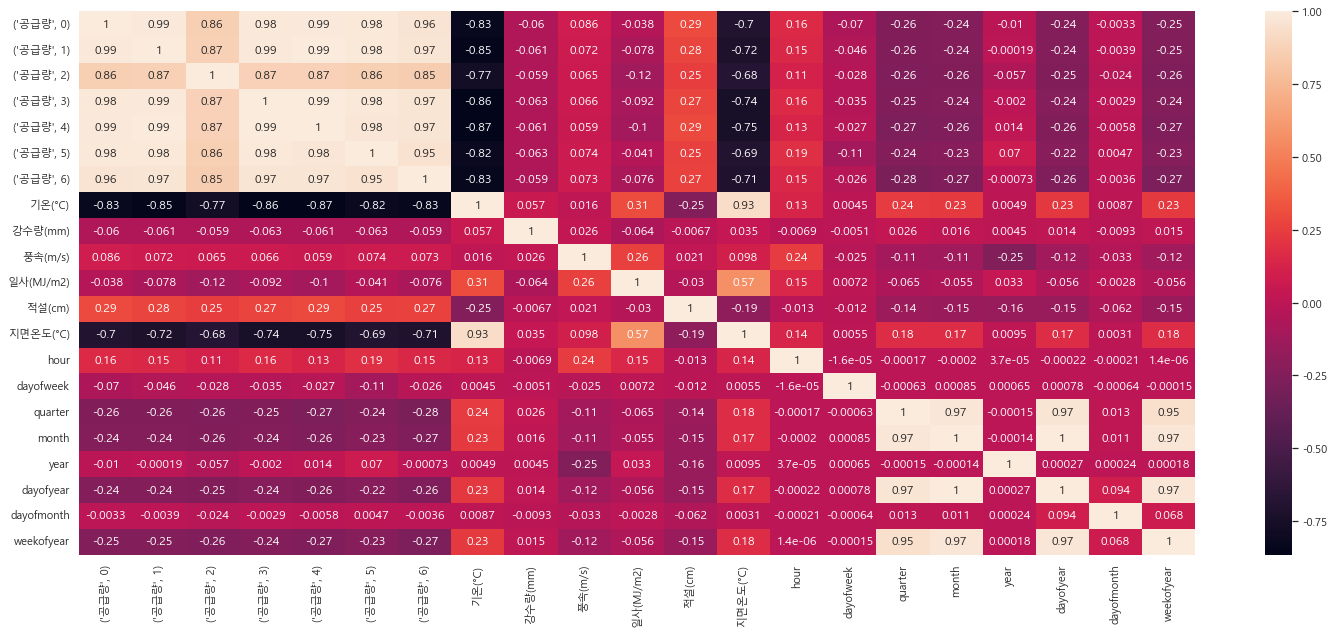

In [331]:
# sns.set(rc = {'figure.figsize':(35,10)})
sns.set(font="Malgun Gothic", 
        rc={"axes.unicode_minus":False, "figure.figsize":(25, 10)},
        style='darkgrid')
sns.heatmap(df2.corr(), annot=True)

- 지면온도 vs 기온 한 개만 쓰기
- 날짜 관련해서 하나씩 정하기 > 모델링 후 feature 선택 : 
  quater vs month, quater vs dayofweek, quater vs weekofday, month vs day of week, month vs weekofyear, dayofweek vs dayofyear 

In [332]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 52580 entries, 0 to 52579
Data columns (total 22 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        52580 non-null  datetime64[ns]
 1   (공급량, 0)    52580 non-null  float64       
 2   (공급량, 1)    52580 non-null  float64       
 3   (공급량, 2)    52580 non-null  float64       
 4   (공급량, 3)    52580 non-null  float64       
 5   (공급량, 4)    52580 non-null  float64       
 6   (공급량, 5)    52580 non-null  float64       
 7   (공급량, 6)    52580 non-null  float64       
 8   기온(°C)      52580 non-null  float64       
 9   강수량(mm)     52580 non-null  float64       
 10  풍속(m/s)     52580 non-null  float64       
 11  일사(MJ/m2)   52580 non-null  float64       
 12  적설(cm)      52580 non-null  float64       
 13  지면온도(°C)    52580 non-null  float64       
 14  hour        52580 non-null  int64         
 15  dayofweek   52580 non-null  int64         
 16  quarter     52580 non-

In [333]:
df2 = df2.drop(['지면온도(°C)', 'quarter', 'weekofyear', 'dayofyear', 'dayofweek'], axis=1)

In [347]:
y_list = [('공급량', 0), ('공급량', 1), ('공급량', 2), ('공급량', 3), ('공급량', 4), ('공급량', 5), ('공급량', 6)]

In [342]:
df2.head()

,time,"(공급량, 0)","(공급량, 1)","(공급량, 2)","(공급량, 3)","(공급량, 4)","(공급량, 5)","(공급량, 6)",기온(°C),강수량(mm),풍속(m/s),일사(MJ/m2),적설(cm),hour,month,year,dayofmonth
0,2013-01-01 01:00:00,2497.129,2169.093,226.178,1434.516,3272.837,3560.365,562.964,-8.5,0.0,4.0,0.0,6.4,1,1,2013,1
1,2013-01-01 02:00:00,2363.265,2051.733,215.778,1345.636,3057.125,3354.245,531.228,-8.4,0.0,4.0,0.0,6.4,2,1,2013,1
2,2013-01-01 03:00:00,2258.505,1923.253,202.178,1270.756,2907.765,3115.757,496.276,-8.1,0.0,3.4,0.0,6.4,3,1,2013,1
3,2013-01-01 04:00:00,2243.969,1927.253,198.978,1322.036,2930.789,3034.237,489.396,-8.2,0.0,3.8,0.0,6.4,4,1,2013,1
4,2013-01-01 05:00:00,2344.105,2047.333,200.578,1421.956,3067.805,3050.469,535.420,-8.2,0.0,4.4,0.0,6.4,5,1,2013,1


In [344]:
df2[('공급량', 1)]

0        2169.093
1        2051.733
2        1923.253
3        1927.253
4        2047.333
           ...   
52575    2600.525
52576    2668.688
52577    2606.681
52578    2540.169
52579    2407.945
Name: (공급량, 1), Length: 52580, dtype: float64

In [ ]:
f, ax = plt.subplots(nrows=len(y_list), ncols=1, figsize=(15, 25))

for i, k in enumerate(y_list):
    sns.lineplot(x=df2['time'], y=df2[k].fillna(method='ffill'), ax=ax[i])


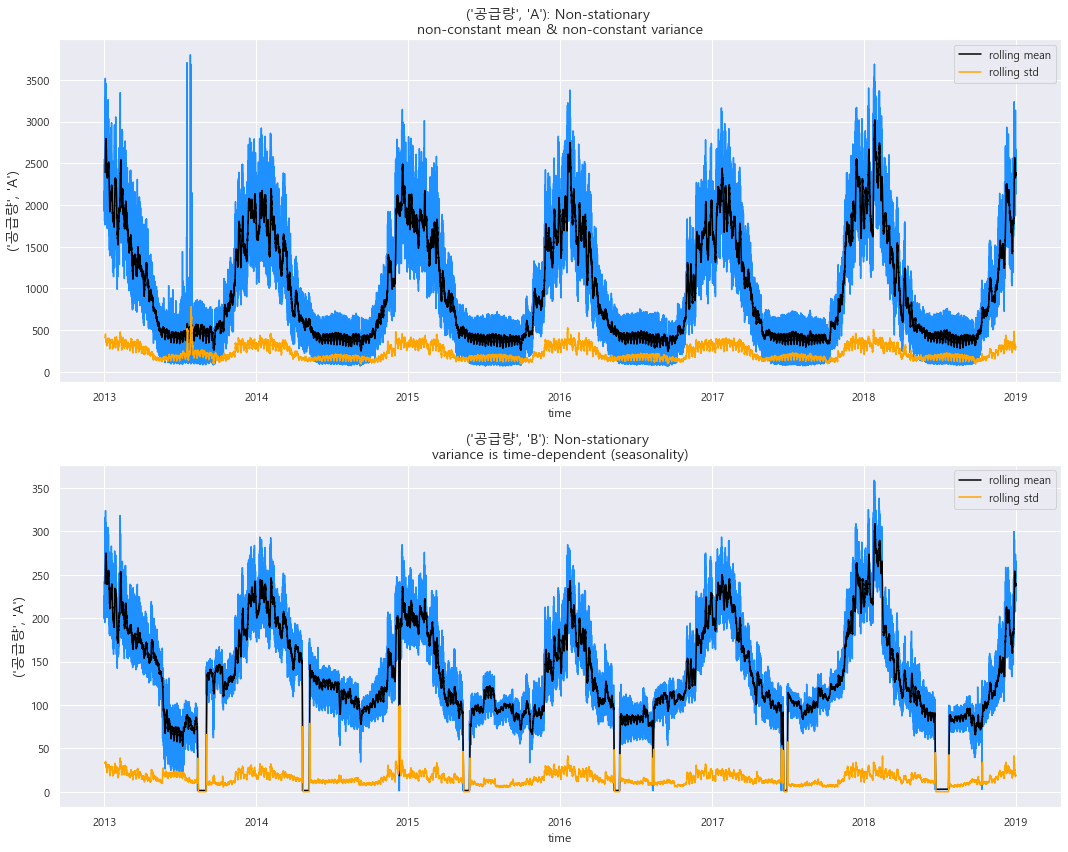

In [345]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['time'], y=df[('공급량', 1)], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['time'], y=df[('공급량', 1)].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['time'], y=df[('공급량', 1)].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title("('공급량', 'A'): Non-stationary \nnon-constant mean & non-constant variance", fontsize=14)
ax[0].set_ylabel(ylabel="('공급량', 'A')", fontsize=14)
# ax[0].set_xlim([time(2013, 1, 1), time(2018, 12, 31)])

sns.lineplot(x=df['time'], y=df[('공급량', 2)], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['time'], y=df[('공급량', 2)].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['time'], y=df[('공급량', 2)].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title("('공급량', 'B'): Non-stationary \nvariance is time-dependent (seasonality)", fontsize=14)
ax[1].set_ylabel(ylabel="('공급량', 'A')", fontsize=14)
# ax[1].set_xlim([time(2013, 1, 1), time(2018, 12, 31)])

plt.tight_layout()
plt.show()

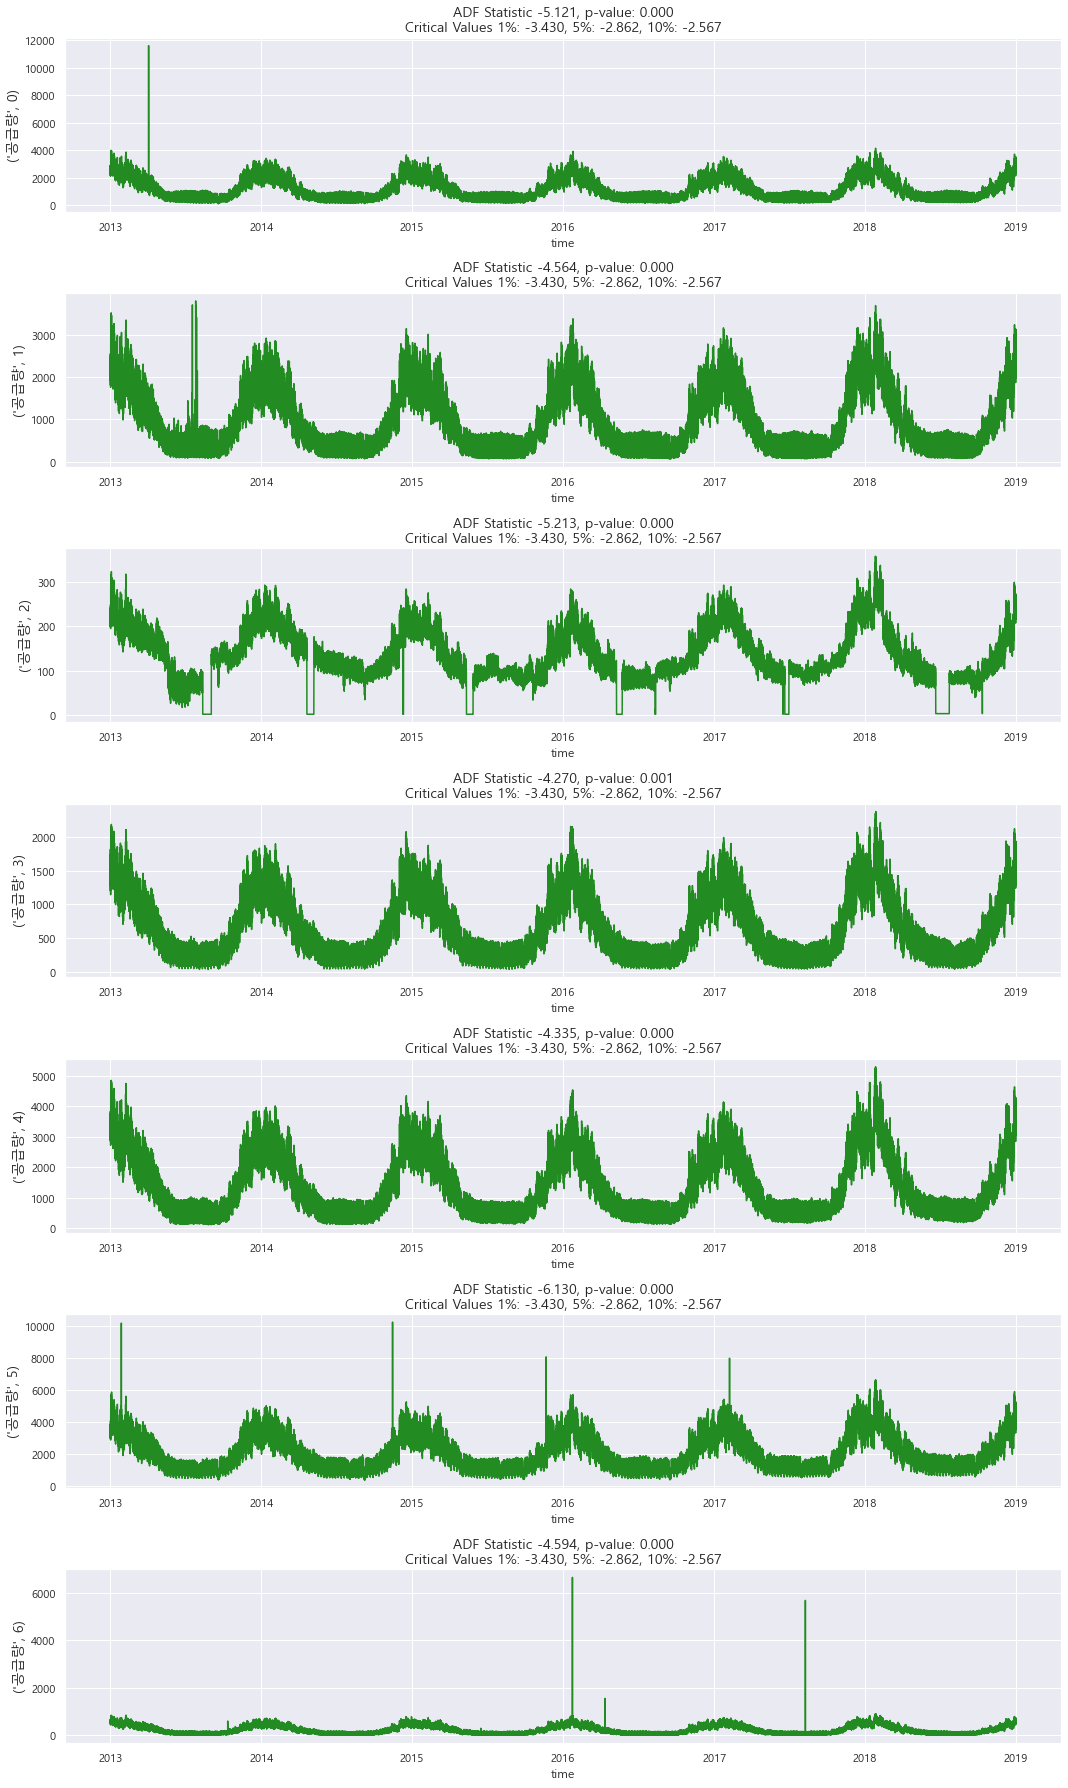

In [348]:
# Thanks to https://www.kaggle.com/iamleonie for this function!
f, ax = plt.subplots(nrows=len(y_list), ncols=1, figsize=(15, 25))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen' 
    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'
    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'
    else:
        linecolor = 'purple'
    sns.lineplot(x=df2['time'], y=series, ax=ax, color=linecolor)
    ax.set_title(f'ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)
    ax.set_ylabel(ylabel=title, fontsize=14)

    
for i, k in enumerate(y_list):
    visualize_adfuller_results(df2[k].values, k, ax[i])

# f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()

p-value <0.05 -> Reject H0, 
- 데이터는 non-stationary 임 => ARIMA같은 모델에 적용하려면 transformation이 필요함
- transformation : log or square root to stabilize non-constant variance
- differencing : subtracts the current value from the previous

In [ ]:
# # Log Transform of absolute values
# # (Log transoform of negative values will return NaN)
# df2['A_공급량_log'] = np.log(abs(df2[('공급량', 'A')]))

# f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
# visualize_adfuller_results(df2['A_공급량_log'], 'Transformed \n 공급량 A', ax[0])

# sns.distplot(df2['A_공급량_log'], ax=ax[1])

In [ ]:
# # First Order Differencing
# ts_diff = np.diff(df2[('공급량', 'A')])
# df2['공급량_A_diff_1'] = np.append([0], ts_diff)

# f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
# visualize_adfuller_results(df2['공급량_A_diff_1'], 'Differenced (1. Order) \n 공급량 A', ax)


## 데이터 정규화

In [ ]:
from sklearn.preprocessing import MinMaxScaler

## train, val 나누기

In [349]:
train_year = [2013, 2014, 2015, 2016, 2017]
val_year = [2018]

In [350]:
train = df2[df2['year'].isin(train_year)]
val = df2[df2['year'].isin(val_year)]

In [351]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 43821 entries, 0 to 43820
Data columns (total 17 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   time        43821 non-null  datetime64[ns]
 1   (공급량, 0)    43821 non-null  float64       
 2   (공급량, 1)    43821 non-null  float64       
 3   (공급량, 2)    43821 non-null  float64       
 4   (공급량, 3)    43821 non-null  float64       
 5   (공급량, 4)    43821 non-null  float64       
 6   (공급량, 5)    43821 non-null  float64       
 7   (공급량, 6)    43821 non-null  float64       
 8   기온(°C)      43821 non-null  float64       
 9   강수량(mm)     43821 non-null  float64       
 10  풍속(m/s)     43821 non-null  float64       
 11  일사(MJ/m2)   43821 non-null  float64       
 12  적설(cm)      43821 non-null  float64       
 13  hour        43821 non-null  int64         
 14  month       43821 non-null  int64         
 15  year        43821 non-null  int64         
 16  dayofmonth  43821 non-

In [352]:
train = train.set_index('time')
val = val.set_index('time')

In [353]:
y_train = train[y_list]
X_train = train.drop(y_list, axis=1)
y_val = val[y_list]
X_val = val.drop(y_list, axis=1)

In [354]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape

((43821, 9), (43821, 7), (8759, 9), (8759, 7))

# 학습

In [394]:
# 대회용 공식
def nmae(true_df, pred_df):
    true = true_df.iloc[:,0].to_numpy()
    pred = pred_df.iloc[:,0].to_numpy()
    score = np.mean((np.abs(true-pred))/true)
    return score

## XGboost

### XGboost 모델 만들기

In [395]:
reg = xgb.XGBRegressor()
reg.fit(X_train, y_train[('공급량', 0)],
        eval_set=[(X_train, y_train[('공급량', 0)]), (X_val, y_val[('공급량', 0)])],
        early_stopping_rounds=50,
       verbose=False)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [396]:
from sklearn import model_selection
rf_parameters = {'n_estimators':[100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 2000, 3000]}
grid_search_xg = model_selection.GridSearchCV(estimator=reg, param_grid=rf_parameters)

In [398]:
for i in y_list:
    grid_search_xg.fit(X_train, y_train[i],
        eval_set=[(X_train, y_train[i]), (X_val, y_val[i])],
        early_stopping_rounds=50,
       verbose=False)
    best_xg  = grid_search_xg.best_estimator_
    val['y_xgboost'] = best_xg.predict(X_val)
    print(i, nmae(val[[i]], val[['y_xgboost']]))

('공급량', 0) 0.10883055071282972
('공급량', 1) 0.10743851052331624
('공급량', 2) 2.831021365075465
('공급량', 3) 0.11711610156808527
('공급량', 4) 0.10823879967392734
('공급량', 5) 0.12755400062070213
('공급량', 6) 0.10207873689913616


In [ ]:
val['y_xgboost'] = best_xg.predict(X_val)
_ = val[['y_xgboost', i]].plot(figsize=(15, 5), alpha=0.5)

In [373]:
best_xg  = grid_search_xg.best_estimator_
best_xg 

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=100, n_jobs=16,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

### prediction vs real 그래프

In [ ]:
val['y_xgboost'] = best_xg.predict(X_val)
_ = val[['y_xgboost', ('공급량', 0)]].plot(figsize=(15, 5), alpha=0.5)

### Error

In [377]:
nmae(val[[('공급량', 0)]], val[['y_xgboost']])

0.10883055071282972

## Prohet

In [389]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
from fbprophet import Prophet

# Train the model
model = Prophet()
model.fit(train)

# x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# Predict on valid set
y_pred = model.predict(x_valid)


ModuleNotFoundError: No module named 'fbprophet'

^C


## LSTM

In [118]:
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv1D, LSTM, Input, TimeDistributed
from tensorflow.keras.models import Model

from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.layers import LSTM

model = Sequental()
model.add(LSTM(16,
              input_shape=(X_train.shape[1], X_train.shape[2]),
              activation='relu',
              return_squences=False)
         )
model.add(Dense(1))

NameError: name 'Sequental' is not defined

In [ ]:
import lightgbm as lgb

In [ ]:
d_train = lgb.Dataset(train_x, train_y)
d_val = lgb.Dataset(val_x, val_y)

params = {
    'objective':'regression',
    'metric':'mae',
    'seed':42
}


In [ ]:
model = lgb.train(params, d_train, 500, d_val, verbose_eval=20, early_stopping_rounds=10)

# 추론 및 결과 제출

In [ ]:
test = pd.read_csv('./test.csv')
submission = pd.read_csv('./sample_submission.csv')

In [ ]:
test.head()

In [ ]:
submission.head()

In [ ]:
test['일자'] = test['일자|시간|구분'].str.split(' ').str[0]
test['시간'] = test['일자|시간|구분'].str.split(' ').str[1].astype(int)
test['구분'] = test['일자|시간|구분'].str.split(' ').str[2]

In [ ]:
test['일자'] = pd.to_datetime(test['일자'])
test['year'] = test['일자'].dt.year
test['month'] = test['일자'].dt.month
test['day'] = test['일자'].dt.day
test['weekday'] = test['일자'].dt.weekday

In [ ]:
test['구분'] = test['구분'].map(d_map)

In [ ]:
test_x = test[features]

In [ ]:
test_x

In [ ]:
preds = model.predict(test_x)

In [ ]:
submission['공급량'] = preds

In [ ]:
submission.to_csv('baseline.csv', index=False)